# Detecting Model Misspecification in Amortized Posterior Inference

## Table of Contents
 * [Introduction](#introduction)
 * [Model specification](#model_specification)
 * [Training](#training)
	 * [Training loop](#training_loop)
	 * [Diagnostics](#diagnostics)
	 * [Inspecting the summary space](#inspecting_the_summary)
 * [Observed Data: Misspecification Detection](#observed_data__misspecification)
	 * [Visualization in data space](#visualization_in_data)
	 * [Detecting misspecification in summary space](#detecting_misspecification_in)
 * [Hypothesis test for observed data](#hypothesis_test_for)
 * [Sensitivity to Misspecification](#sensitivity_to_misspecification)
	 * [Computing Sensitivity](#computing_sensitivity)
	 * [Plotting the results](#plotting_the_results)

In [ ]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import bayesflow as bf
from bayesflow import computational_utilities as utils

matplotlib.rcParams["figure.dpi"] = 72

## Introduction <a class="anchor" id="introduction"></a>


Under certain regularity conditions, the theory on simulation-based inference assures that the (amortized) neural posterior estimator $q_{\phi}$ samples from the exact posterior $p(\theta\,|\,x)$ after convergence.

However, the neural posterior approximator is optimized with respect to the "prior prredictive distribution" of the generative model which we specify for the training process.
When the generative model at test time (aka "true data generating process") deviates from the one used during training, the guarantees for the approximate neural posterior no longer hold and the approximate posterior samples can be wrong in essentially arbitrary ways.

The precise definition of model misspecification in amortized inference, along with extensive implications and experiments, can be gleaned in the following pre-print: https://arxiv.org/abs/2112.08866

<img src="img/model_misspecification_amortized_sbi.png"/>

## Model specification <a class="anchor" id="model_specification"></a>


The general Bayesian forward model can be formulated as a two-step process:

$$
\theta \sim p(\theta) \qquad x\sim p(x|\theta)
$$


For this showcase example, we specify a fairly simple generative model where the means of a 2-dimensional Gaussian shall be estimated: $\theta=\mu=(\mu_1, \mu_2)$. The likelihood $p(x|\theta)$ is a Gaussian $\mathcal{N}(\mu, \Sigma)$ with location $\mu$ and covariance matrix $\Sigma$. The prior distribution $p(\theta)$ over the inference targets is again a Gaussian $\mathcal{N}(\mu_0, \Sigma_0)$ with location $\mu_0$ and covariance $\Sigma_0$.

Consequently, the forward model is

$$
\mu\sim\mathcal{N}(\mu_0, \Sigma_0) \qquad x\sim\mathcal{N}(\mu, \Sigma)
$$

with fixed parameters $\mu_0, \Sigma_0, \Sigma$, and we want to perform posterior inference over the parameter vector $\mu$.

We choose $\mu_0=0, \Sigma_0=\mathbb{I}, \Sigma=\mathbb{I}$ as fixed parameters of the generative model for training the neural posterior approximator. Each simulated data set contains $N=100$ observations:

In [2]:
def prior(D=2, mu=0.0, sigma=1.0):
    """Gaussian prior random number generator."""
    return np.random.default_rng().normal(loc=mu, scale=sigma, size=D)


def simulator(theta, n_obs=100, scale=1.0):
    """Gaussian likelihood random number generator."""
    return np.random.default_rng().normal(loc=theta, scale=scale, size=(n_obs, theta.shape[0]))


generative_model = bf.simulation.GenerativeModel(
    prior=prior, simulator=simulator, name="Generative Model: Training", simulator_is_batched=False
)

INFO:root:Performing 2 pilot runs with the Generative Model: Training model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


## Training <a class="anchor" id="training"></a>


We choose a `DeepSet` architecture [1] to learn 2 permutation-invariant summary statistics from the data, which are then passed to the posterior network and jointly optimized.
The Inference network is a standard `InvertibleNetwork` with two coupling layers and the `AmortizedPosterior` combines the inference and summary networks. Since we desire model misspecification detection via a structured summary space [2], we select `summary_loss_fun="MMD"` and the amortizer combines its losses correctly.
Finally, the `trainer` wraps the generative model and the amortizer into a consistent object for training and subsequent sampling.

[1] Zaheer et al. (2017): https://arxiv.org/abs/1703.06114

[2] Schmitt et al. (2022): https://arxiv.org/abs/2112.08866

In [3]:
summary_net = bf.networks.DeepSet(summary_dim=2)
inference_net = bf.networks.InvertibleNetwork(num_params=2, num_coupling_layers=2)
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, summary_loss_fun="MMD")
trainer = bf.trainers.Trainer(generative_model=generative_model, amortizer=amortizer, memory=True)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


### Training loop <a class="anchor" id="training_loop"></a>


Because the inference problem is simple and illustrative, we just train for 15 epochs with 500 iterations per epoch and a batch size of 32.

In [ ]:
losses = trainer.train_online(epochs=15, iterations_per_epoch=500, batch_size=32)

### Diagnostics <a class="anchor" id="diagnostics"></a>


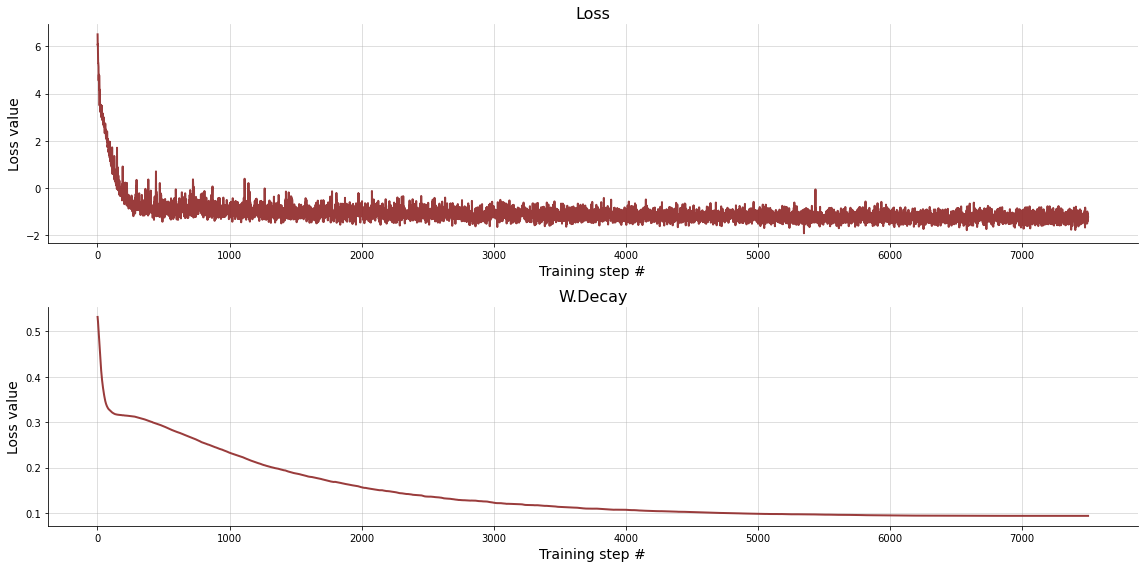

In [5]:
fig = bf.diagnostics.plot_losses(losses)

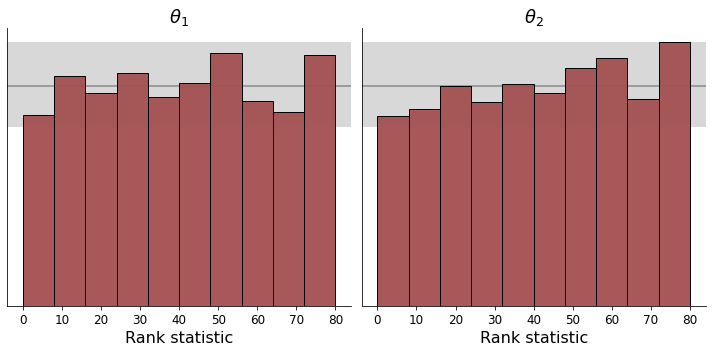

In [6]:
fig = trainer.diagnose_sbc_histograms()

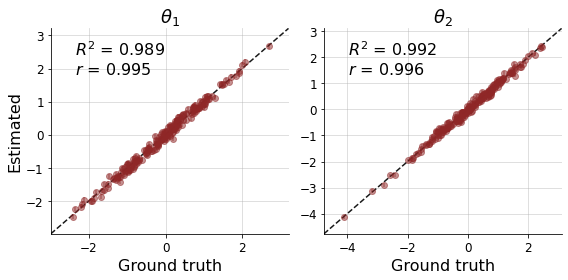

In [7]:
new_sims = trainer.configurator(trainer.generative_model(200))
posterior_draws = amortizer.sample(new_sims, n_samples=500)
fig = bf.diagnostics.plot_recovery(posterior_draws, new_sims["parameters"])

### Inspecting the summary space <a class="anchor" id="inspecting_the_summary"></a>

In fact, the summary space has essentially converged to a unit Gaussian for samples from the generative model which we used to train the networks.

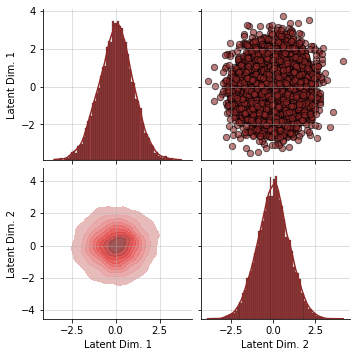

In [8]:
simulations = trainer.configurator(trainer.generative_model(10000))
summary_statistics = trainer.amortizer.summary_net(simulations["summary_conditions"])
theta = simulations["parameters"]

_ = bf.diagnostics.plot_latent_space_2d(summary_statistics)

## Observed Data: Misspecification Detection <a class="anchor" id="observed_data__misspecification"></a>

After assessing the converged neural posterior approximator's performance for the reference model used for training, we will now perform inference on data from a different data generating process. In a real-life analysis, this would be the observed data $x_{\text{obs}}$ from an experiment or study.

For this illustration, we choose the prior scale $\tau_0$ as the source of misspecification. That means that we observe 1000 data sets $\{x_{\text{obs}}^{(k)}\}_{k=1}^{1000}$ from a generative model with prior scale $\tau_0=4$. Consequently, the prior covariance is $4\cdot\mathbb{I}=\begin{pmatrix}4&0\\0&4\end{pmatrix}$. The remaining fixed parameters $\mu_0$ and $\Sigma$ are unaltered.

In [9]:
def prior_obs(D=2, mu=0.0, sigma=4.0):
    """Gaussian prior random number generator."""
    return np.random.default_rng().normal(loc=mu, scale=sigma, size=D)


def simulator_obs(theta, n_obs=100, scale=1.0):
    """Gaussian likelihood random number generator"""
    return np.random.default_rng().normal(loc=theta, scale=scale, size=(n_obs, theta.shape[0]))


generative_model_obs = bf.simulation.GenerativeModel(
    prior=prior_obs, simulator=simulator_obs, name="Generative Model: Observed", simulator_is_batched=False
)

INFO:root:Performing 2 pilot runs with the Generative Model: Observed model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [10]:
# 1000 simulated data sets from the well-specified model from training (for reference)
simulations = trainer.configurator(trainer.generative_model(1000))
x = simulations["summary_conditions"]

# 1000 "observed" data sets with different prior covariance
simulations_obs = trainer.configurator(generative_model_obs(1000))
x_obs = simulations_obs["summary_conditions"]

### Visualization in data space <a class="anchor" id="visualization_in_data"></a>


Let's visualize some of the data $x_{\text{obs}}$ from that generative model. This plot lives in the data domain $\mathbb{R}^2$ and depicts the data $x_{\text{obs}}$. Each color is one data set $k=1,\ldots,1000$, and all points of one color form the respective data set $x_{\text{obs}}^{(k)}$.

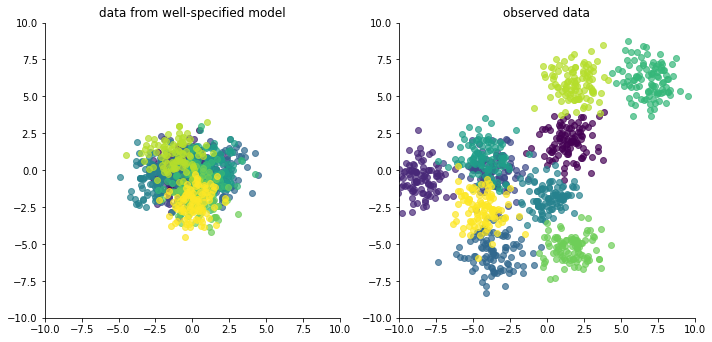

In [11]:
n_data_sets_visualization = 10
colors = cm.viridis(np.linspace(0, 1, n_data_sets_visualization))
indices = list(range(n_data_sets_visualization))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
for idx, c in zip(indices, colors):
    ax1.scatter(x[idx, :, 0], x[idx, :, 1], color=c, alpha=0.7)
    ax2.scatter(x_obs[idx, :, 0], x_obs[idx, :, 1], color=c, alpha=0.7)

for ax in (ax1, ax2):
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_aspect("equal")
    sns.despine()

ax1.set_title("data from well-specified model")
ax2.set_title("observed data")
fig.tight_layout()

### Detecting misspecification in summary space <a class="anchor" id="detecting_misspecification_in"></a>

As proposed in our paper [2], we will detect the deviating observed data as deviations in the structured summary space. Therefore, we compute the learned summary statistics of the well-specified data $h_{\psi}(x)$ and for the observed data $h_{\psi}(x_{\text{obs}})$ by a simple pass through the trainer's summary network $h_{\psi}$.


[2] Schmitt et al (2021): https://arxiv.org/abs/2112.08866

In [12]:
summary_statistics = trainer.amortizer.summary_net(x)
summary_statistics_obs = trainer.amortizer.summary_net(x_obs)

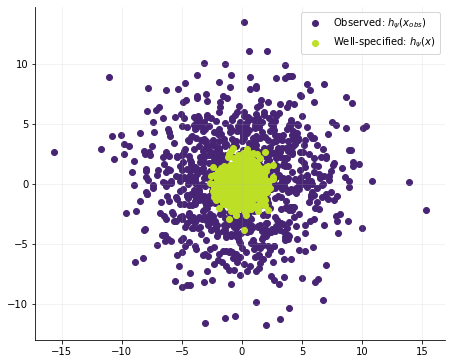

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors = cm.viridis(np.linspace(0.1, 0.9, 2))
ax.scatter(
    summary_statistics_obs[:, 0], summary_statistics_obs[:, 1], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
)
ax.scatter(summary_statistics[:, 0], summary_statistics[:, 1], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
ax.legend()
ax.grid(alpha=0.2)
plt.gca().set_aspect("equal")
sns.despine(ax=ax)

The summary space shows a regular pattern and does not fail in an arbitrary way.This visual discrepancy can be quantified in many ways. In this case, we choose the *Maximum Mean Discrepancy*, more specifically its biased estimator [3], as implemented in `bayesflow.computational_utilities.maximum_mean_discrepancy`.
The larger the MMD, the more do the samples deviate.

[3] Gretton (2012): https://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf

In [14]:
mmd = utils.maximum_mean_discrepancy(summary_statistics, summary_statistics_obs)
print(f"Estimated MMD in summary space: {mmd:.3f}")

Estimated MMD in summary space: 1.938


## Hypothesis test for observed data <a class="anchor" id="hypothesis_test_for"></a>

In real-life modeling scenarios, a researcher might desire to perform inference on observed data $x_{\text{obs}}$. After training the neural posterior estimator with samples from a generative model $\mathcal{M}$, the natural question arises: "Is the model $\mathcal{M}$ well-specified for the observed data $x_{\text{obs}}$?"


To answer this question, we can perform a frequentist hypothesis test on the summary MMD distances. First, we need to gather samples from the sampling distribution of MMD under a well-specified model. This is straight-forward because by definition the model $\mathcal{M}$ is well-specified with respect to itself. Thus, we will generate a reference sample from the training model $\mathcal{M}$ and estimate the summary MMD to samples from $\mathcal{M}$ itself.

**Note:** It is important that the number of simulated data sets to estimate the sampling distribution of the summary under the null hypothesis matches the number of observed data sets. This is because the MMD estimator is biased and we need comparable values for the sampling distribution and the observed summary MMD. Therefore, the `bayesflow.computational_utilities.compute_mmd_hypothesis_test` function needs either `observed_data` or `n_observed_data_sets` directly to determine the number of data sets for the estimation of the MMD sampling distribution.

We start by creating some observed data $x_{\text{obs}}$ from the generative model of the trainer. We expect our model to be well-specified for these data (up to the type I error rate of $5\%$). We simulate and test against 10 "observed" data sets.

  0%|          | 0/500 [00:00<?, ?it/s]

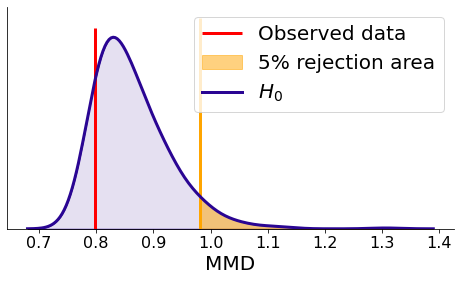

In [15]:
# 1000 simulated data sets from the well-specified model from training (for reference)
observed_data = trainer.configurator(trainer.generative_model(10))

MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=False
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

Now, let's plug in some observed data from a different generative model. We will use the generative model from above, where the prior covariance is larger. We see that the misspecification is clearly detectable. In practice, we would conclude that our neural posterior estimator $q_{\phi}$ is not trustworthy and we should reiterate on the generative model we use to train the neural networks.

  0%|          | 0/500 [00:00<?, ?it/s]

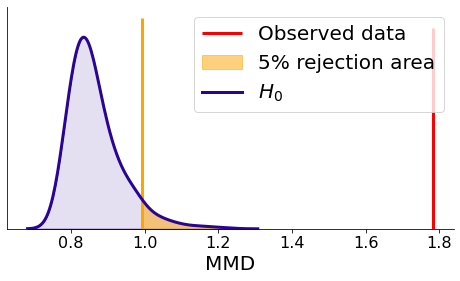

In [16]:
# 10 "observed" data sets with different prior covariance (see above)
observed_data = trainer.configurator(generative_model_obs(10))

MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=False
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

We can also speed up the computations by using bootstraps of the reference data to generate the MMD distribution under the null hypothesis (`bootstrap=True`). This is particularly helpful if the simulator is computationally expensive and a large number of simulations is not computationally feasible.

Here, we also provide the reference data ourselves, but bootstrapping can be performed either way.

  0%|          | 0/500 [00:00<?, ?it/s]

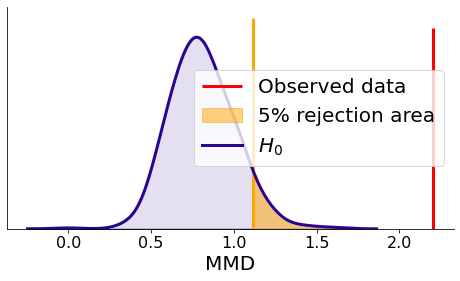

In [17]:
reference_data = trainer.configurator(trainer.generative_model(10))
observed_data = trainer.configurator(generative_model_obs(10))

MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

## Sensitivity to Misspecification <a class="anchor" id="sensitivity_to_misspecification"></a>

The submodule `bayesflow.sensitivity` contains functions to analyze the sensitivity of a converged `Trainer` (i.e., the neural posterior estimator) to model misspecification.

We start by redefining the generative model with the possibility to increase the model's misspecification through two settings `p1` and `p2`. Therefore, we define a function `generative_model_misspecified(p1, p2)`. The function takes the settings `p1` and `p2` as input and returns a (potentially misspecified) generative model.

In our Gaussian example, we let `p1` control the prior location ($\mu_0=\mathtt{p1}$) while `p2` controls the scale of a diagonal covariance matrix $\Sigma_0$ such that $\Sigma_0=\mathtt{p2}\cdot\mathbb{I}$. In this example, both settings cause prior misspecification. Inducing other types of misspecification (e.g., simulator or noise) follows the same principle.

The consequence: If `p1=0` and `p2=1`, the `generative_model_misspecified` function yields the original well-specified model from training. For all other values for `p1` and `p2`, the resulting generative model differs.

**Implementation details:** 

- The `partial` application pattern lets us pre-load the `prior` with custom arguments and pass this pre-loaded function into the generative model. We use this technique to use `p1` and `p2` as parameters in the prior callable.
- We skip the generative model's consistency checks and setup outputs via `skip_test=True`.

In [18]:
from functools import partial


def generative_model_misspecified(p1, p2):
    prior_ = partial(prior, D=2, mu=p1, sigma=p2)
    simulator_ = partial(simulator, scale=1.0)
    generative_model_ = bf.simulation.GenerativeModel(prior_, simulator_, simulator_is_batched=False, skip_test=True)
    return generative_model_

In the next step, we provide meta-information for the sensitivity analysis:

- Names of the settings `p1` and `p2`: proper axis labels
- Range of the settings `p1` and `p2`: defining the experiment's grid
- well-specified value for the settings `p1` and `p2` (i.e., `p1=0` and `p2=1` in our example): dashed lines for the baseline configuration in the plots

In [19]:
p1_config = {
    "name": r"$\mu_0$ (prior location)",
    "values": np.linspace(-0.1, 3.1, num=20),
    "well_specified_value": 0.0,
}
p2_config = {
    "name": r"$\tau_0$ (prior scale)",
    "values": np.linspace(0.1, 10.1, num=20),
    "well_specified_value": 1.0,
}

### Computing Sensitivity <a class="anchor" id="computing_sensitivity"></a>

As described above, the `bf.sensitivity.misspecification_experiment` function requires the converged `Trainer`, the factory for misspecified models, and meta-information on the settings. In addition, the number of posterior samples per simulated data set as well as the total number of simulated data sets per setting configuration can be specified.

In [20]:
posterior_error, summary_mmd = bf.sensitivity.misspecification_experiment(
    trainer=trainer,
    generator=generative_model_misspecified,
    first_config_dict=p1_config,
    second_config_dict=p2_config,
    n_posterior_samples=500,
    n_sim=100,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.99s/it]


### Plotting the results <a class="anchor" id="plotting_the_results"></a>


Model misspecification with respect to both prior location $\mu_0$ and scale $\tau_0$ worsen the average posterior recovery in terms of aggregated RMSE. However, the converged posterior approximator seems to be relatively robust against moderate misspecifications in these parameters.

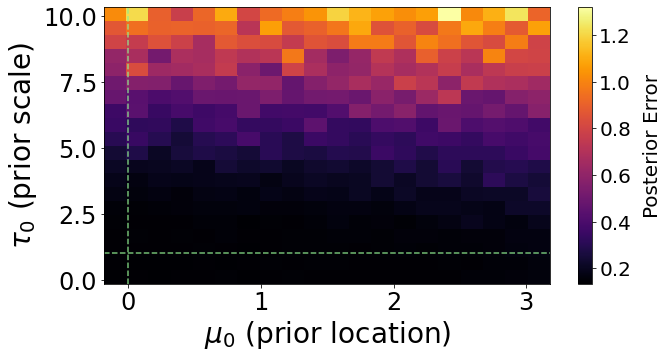

In [21]:
_ = bf.sensitivity.plot_model_misspecification_sensitivity(
    posterior_error, p1_config, p2_config, plot_config={"vmin": None}
)

The MMD plot clearly shows that the summary space MMD is lowest when the model is well-specified (coordinates `(0, 1)`). When either the prior location $\mu_0$ or the prior scale $\tau_0$ changes, the summary MMD increases and we're alerted of the model misspecification.

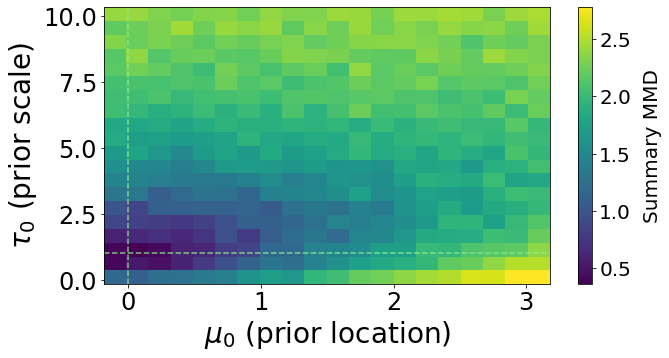

In [22]:
_ = bf.sensitivity.plot_model_misspecification_sensitivity(
    summary_mmd, p1_config, p2_config, plot_config={"vmin": None}
)